# PERSONALIZED RESULTS RANKING APPROACH​

# tf-idf word_embedding

In [1]:
import pandas as pd 
import numpy as np
import sklearn
import random
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

import spacy
from itertools import product
import en_core_web_sm
from scipy.spatial.distance import cosine
nlp = spacy.load("en_core_web_md")

In [2]:
hotel = pd.read_csv('Hotel_Reviews.csv')
## sample the data records
sample_df = hotel.sample(n=5000, random_state=1)

reviews = list(sample_df['Positive_Review'])
#random.seed(1)
#reviews = random.sample(positive, 5000)
##100,000 kernel died
    

In [49]:
for idx, review in enumerate(reviews):
    print(nlp(review))
    print(nlp(review).vector[:10]) 
    
    if idx == 5: # stop printing after first 5 or so, takes a long time!
        break

 Nothing was too much trouble The staff were attentive at all times and the hotel staff made the stay very comfortable 
[-0.02036332  0.11480764 -0.1337123  -0.16508472 -0.05305532  0.03085167
  0.08294568 -0.15408526  0.00287191  2.4965317 ]
 I loved there shower It felt like you were under a fire hose Great hotel 
[ 0.09481687  0.1639115  -0.07088251 -0.16056776  0.05718728 -0.03571013
 -0.00516431 -0.20512375 -0.03641231  2.1244574 ]
 beds really comfy and the location is great also maid was such a sweetheart 
[ 0.09935428  0.12342419 -0.18267745 -0.06830308  0.10166502  0.02186574
  0.09252147 -0.3289746  -0.08778306  2.0171373 ]
 Really nice hotel good facilities great staff and very clean Only minor issue was temperature of main pool Would definitely recommend though 
[ 0.007346    0.18698248 -0.07363852 -0.12694596  0.02017065  0.01363452
  0.04054935 -0.25043872 -0.10213464  2.2373009 ]
 Everything is super And room and design Very clean Super 
[-0.07527246  0.13330118 -0.13143

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews)

tf_idf_lookup_table = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [4]:
DOCUMENT_SUM_COLUMN = "DOCUMENT_TF_IDF_SUM"

# sum the tf idf scores for each document
tf_idf_lookup_table[DOCUMENT_SUM_COLUMN] = tf_idf_lookup_table.sum(axis=1)
available_tf_idf_scores = tf_idf_lookup_table.columns # a list of all the columns we have
available_tf_idf_scores = list(map( lambda x: x.lower(), available_tf_idf_scores)) # lowercase everything

In [5]:
import numpy as np

reviews_vectors = []
for idx, review in enumerate(reviews): # iterate through each review
 
    tokens = nlp(review) # have spacy tokenize the review text
    
    # initially start a running total of tf-idf scores for a document
    total_tf_idf_score_per_document = 0
    
    # start a running total of initially all zeroes (300 is picked since that is the word embedding size used by word2vec)
    running_total_word_embedding = np.zeros(300) 
    for token in tokens: # iterate through each token
    
    # if the token has a pretrained word embedding it also has a tf-idf score
        if token.has_vector and token.text.lower() in available_tf_idf_scores:
            
            tf_idf_score = tf_idf_lookup_table.loc[idx, token.text.lower()]
            #print(f"{token} has tf-idf score of {tf_idf_lookup_table.loc[idx, token.text.lower()]}")
            running_total_word_embedding += tf_idf_score * token.vector
            
            total_tf_idf_score_per_document += tf_idf_score
    
    # divide the total embedding by the total tf-idf score for each document
    ###deqi: avoid dividing by 0
    if total_tf_idf_score_per_document<=0.00001:
        document_embedding = np.random.rand(1,300)[0]
    else:
        document_embedding = running_total_word_embedding / total_tf_idf_score_per_document
    reviews_vectors.append(document_embedding)

In [6]:
len(reviews_vectors)

5000

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = pd.DataFrame(cosine_similarity(reviews_vectors), columns=reviews, index=reviews)

In [8]:
similarities = similarities.unstack().reset_index()
similarities.columns = ["review1", "review2", "similarity"]
similarities = similarities[similarities["similarity"] < 0.9999999999]
similarities.drop_duplicates(subset=["similarity"], inplace=True)

In [9]:
for idx, row in similarities.sort_values(by="similarity", ascending=False).head(50).iterrows():
    print(row["review1"])
    print("--" * 10)
    print(row["review2"])
    print("\n\n")

 Location
--------------------
 Location location and location



 Location location and location
--------------------
 Frear location



 Location location and location
--------------------
 Locatio location location



 the kindness of the staff
--------------------
 The friendliness of the staff



 Location and comforts 
--------------------
 Location and comfort 



 Staff were very helpful and friendly
--------------------
 The staff were very friendly and helpful 



 The bed was extremely comfortable 
--------------------
 Bed was extremely comfortable 



 Breakfast very friendly staff excellent location
--------------------
 Excellent location friendly staff very good breakfast



 The bed was really comfortable 
--------------------
 Bed was really comfortable 



 Good breakfast comfy bed
--------------------
 breakfast n a bed very comfy



 Bed was very comfy
--------------------
 The bed was very comfy



 Friendly and very helpful staff 
--------------------
 Very helpf

## PCA

In [10]:
review=pd.DataFrame(reviews_vectors) #2000 review vector
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(review)

In [11]:
pca.explained_variance_ratio_

array([0.18384327, 0.12613442, 0.07422345, 0.05226313, 0.03988431,
       0.03423041, 0.0262875 , 0.02299236, 0.02216843, 0.01934463])

In [12]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component' + str(i) for i in range(1,11)])

In [13]:
import matplotlib.pyplot as plt

plt.scatter(principalDf.iloc[:,0],principalDf.iloc[:,1])

## TSNE

In [36]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=1,n_components=3).fit_transform(review)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 190.47170209884644 seconds


In [17]:
x1= pd.DataFrame(fashion_tsne).iloc[:,0]
x2= pd.DataFrame(fashion_tsne).iloc[:,1]

In [18]:
len(x1)

5000

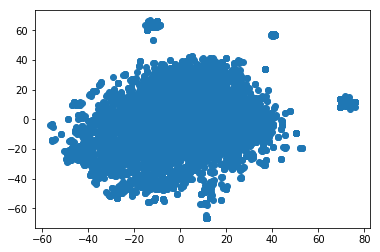

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x1,x2)

# Clustering

## K-means-not preferred

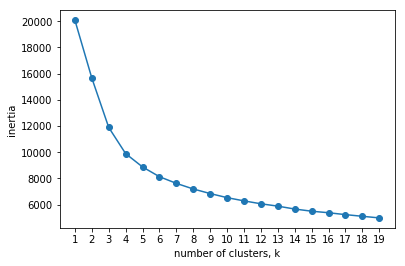

In [15]:
from sklearn.cluster import KMeans
## Since the lower the inertia is the better the model, we can choose the
## n_clusters by doing the following:
ks = range(1, 20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(principalComponents)#fashion_tsne   
    #model.fit(fashion_tsne)#principalComponents    ##both indicate 10 or so
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
## We can't have too many clusters(Overfitting), so we should choose the 
## elbow of the graph,which is the point where inertia starts to decrease
## slowly, in this case, 3 should be the n_cluster

In [16]:
## fit the k-means model
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)###change the number accordingly
cluster_assignments = kmeans.fit_predict(principalComponents)

samp_1=pd.DataFrame(reviews)
samp_1['cluster']=cluster_assignments

samp_1.columns=['review','cluster']
list(samp_1[samp_1['cluster']==0]['review'].values)[:20]

[' Location fantastic',
 ' Good location',
 ' The location',
 ' Excellent location',
 ' Location of hotel',
 ' Good location and good value',
 ' Good location ',
 ' Location was good ',
 ' good location great price',
 ' Good location',
 ' Great location',
 ' Location is excellent',
 ' Great location ',
 ' Convenient location',
 ' Perfect location',
 ' Perfect location ',
 ' Location is excellent',
 ' Top location',
 ' The location',
 ' location was good']

In [40]:
samp_1.head()

,review,cluster
0,good customer service great location,7
1,The room was nice and cosy the bed and pillow...,5
2,excellent location good facilities in hotel,7
3,Staff and location were great,7
4,The customer service was exceptional After a ...,5


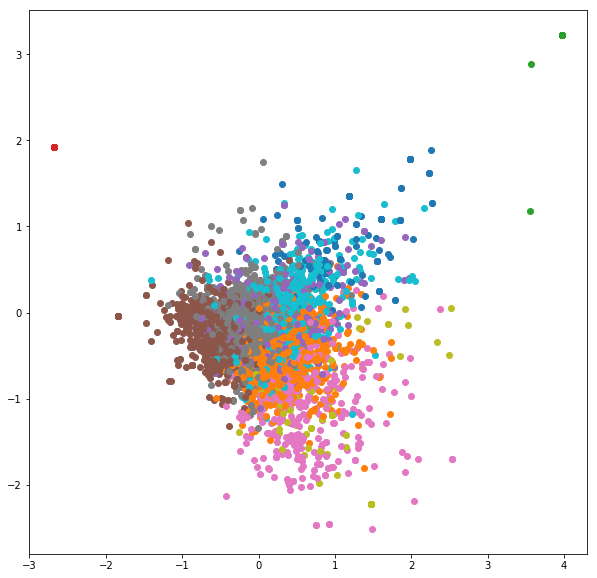

In [17]:
color_map = {
#     0: "r",
#     1: "b",
#     2: "g",
#     3: "y",
#     4:''
    0:'tab:blue', 1:'tab:orange', 2:'tab:green', 3:'tab:red', 4:'tab:purple', 5:'tab:brown', 
    6: 'tab:pink', 7: 'tab:gray', 8: 'tab:olive', 9:'tab:cyan'
    
}



plt.rcParams["figure.figsize"] = (10,10)

for i, vector in enumerate(principalComponents):
    x = vector[0]
    y = vector[1]
    plt.plot(x,y, 'bo', c=color_map[cluster_assignments[i]])
  #  plt.text(x * (1 + 0.01), y * (1 + 0.01) , review_embedding[i], fontsize=12)

## Hierachical clustering

In [28]:
!pip install graphviz

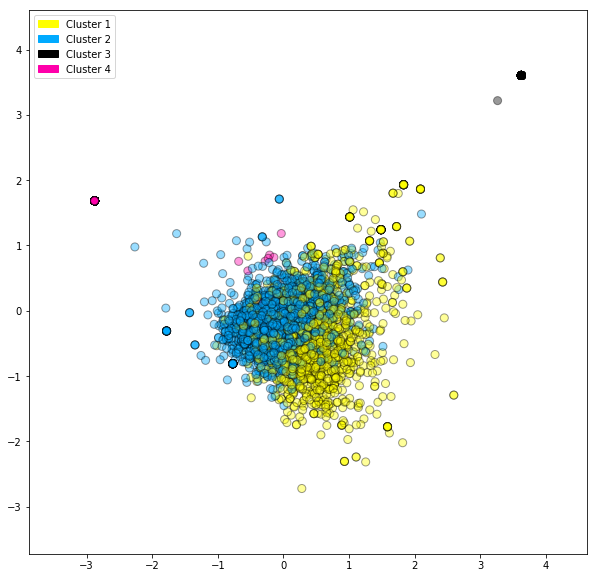

In [32]:
from adspy_shared_utilities import plot_labelled_scatter

from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from adspy_shared_utilities import plot_labelled_scatter

#X, y = make_blobs(random_state = 10)
X=principalComponents

cls = AgglomerativeClustering(n_clusters = 5)
cls_assignment = cls.fit_predict(X)

plot_labelled_scatter(X, cls_assignment, 
        ['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4'])

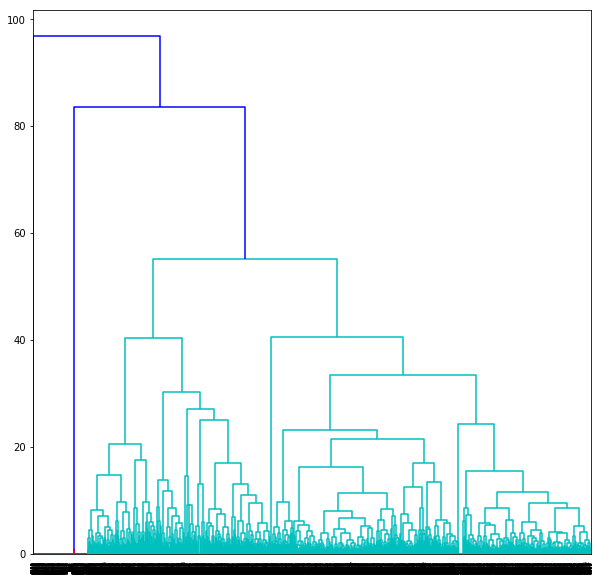

In [33]:
from scipy.cluster.hierarchy import ward, dendrogram
plt.figure()
dendrogram(ward(X))
plt.show()

In [ ]:
### 17-20 clusterd from the dendrogram?

# Group Demo Statistics

In [18]:
samp_1.head()

,review,cluster
0,Nothing was too much trouble The staff were a...,5
1,I loved there shower It felt like you were un...,5
2,beds really comfy and the location is great a...,1
3,Really nice hotel good facilities great staff...,5
4,Everything is super And room and design Very ...,1


In [32]:
sample_df['cluster']=samp_1['cluster'].values

In [34]:
sample_df.head().T

,356054,395957,468352,281462,498978
Hotel_Address,Keizersgracht 148 Amsterdam City Center 1015 C...,Park Lane Westminster Borough London W1K 7TN U...,Ungargasse 60 03 Landstra e 1030 Vienna Austria,Avinguda Icaria 195 Sant Mart 08005 Barcelona ...,Vilamari 34 36 Eixample 08015 Barcelona Spain
Additional_Number_of_Scoring,85,184,116,439,113
Review_Date,11/29/2015,2/17/2017,2/13/2017,3/25/2017,9/20/2015
Average_Score,9.3,7.9,8.1,8,8.3
Hotel_Name,Canal House,Grosvenor House A JW Marriott Hotel,Imperial Riding School Renaissance Vienna Hotel,Hotel SB Icaria Barcelona,Hotel Vilamar
Reviewer_Nationality,United Kingdom,United States of America,Lithuania,United Kingdom,Cyprus
Negative_Review,No Negative,I had a Junior suite The bed was only a queen...,staff could be less rude the pool area is hor...,No Negative,No Negative
Review_Total_Negative_Word_Counts,0,21,12,0,0
Total_Number_of_Reviews,491,564,1395,3633,1127
Positive_Review,Nothing was too much trouble The staff were a...,I loved there shower It felt like you were un...,beds really comfy and the location is great a...,Really nice hotel good facilities great staff...,Everything is super And room and design Very ...


In [35]:
sample_df.to_csv('ten_clusters.csv')

# QUALITY PREFERENCE FILTER APPROACH

In [2]:
import pandas as pd 
import numpy as np
import sklearn
import random
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [3]:
data=pd.read_csv('Hotel_Reviews.csv', encoding='utf-8')
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


# processing tags

In [4]:
tag = data.Tags.str.extract(r'\[(.+)\]').iloc[:,0].str.split(',')

In [5]:
tag

0         [' Leisure trip ',  ' Couple ',  ' Duplex Doub...
1         [' Leisure trip ',  ' Couple ',  ' Duplex Doub...
2         [' Leisure trip ',  ' Family with young childr...
3         [' Leisure trip ',  ' Solo traveler ',  ' Dupl...
4         [' Leisure trip ',  ' Couple ',  ' Suite ',  '...
5         [' Leisure trip ',  ' Group ',  ' Duplex Doubl...
6         [' Leisure trip ',  ' Group ',  ' Duplex Twin ...
7         [' Leisure trip ',  ' Couple ',  ' Duplex Doub...
8         [' Leisure trip ',  ' Couple ',  ' Duplex Doub...
9         [' Leisure trip ',  ' Couple ',  ' Large King ...
10        [' Leisure trip ',  ' Group ',  ' Duplex Doubl...
11        [' Business trip ',  ' Solo traveler ',  ' Dup...
12        [' Leisure trip ',  ' Solo traveler ',  ' Dupl...
13        [' Business trip ',  ' Solo traveler ',  ' Dup...
14        [' Leisure trip ',  ' Family with young childr...
15        [' Leisure trip ',  ' Couple ',  ' Duplex Doub...
16        [' Leisure trip ',  ' Family w

In [6]:
tag1 = [list(map(lambda x:x[2:-2], tag[n])) for n in range(len(tag))]

In [7]:
tag2 = []
for i in tag1:
    if i[0] != 'With a pet':
        tag2.append(['NA']+i)
    else: tag2.append(i)

In [8]:
df1=pd.DataFrame(tag2)

In [9]:
df1.iloc[:,0].value_counts()

NA            514333
With a pet      1405
Name: 0, dtype: int64

In [10]:
for i in tag2:
    if i[1] not in ['Business trip',"Leisure trip"]:
        i.insert(1,'NA')

In [11]:
df1=pd.DataFrame(tag2)
df1.iloc[:,1].str.strip().value_counts()

Leisure trip     416672
Business trip     82748
NA                16318
Name: 1, dtype: int64

In [12]:
for i in tag2:
    if i[2].strip() not in ['Couple',"Solo traveler",'Group','Family with young children','Family with older children','Travelers with friends']:
        i.insert(2,'NA')

In [13]:
df1=pd.DataFrame(tag2)
df1.iloc[:,2].str.strip().value_counts()

Couple                        251596
Solo traveler                 108368
Group                          65263
Family with young children     60809
Family with older children     26262
Travelers with friends          2143
NA                              1297
Name: 2, dtype: int64

In [14]:
for i in tag2:
    if len(i)<4:
        i.append('NA')
    elif i[3].strip() != '2 rooms':
        i.insert(3,'NA')

In [15]:
df1=pd.DataFrame(tag2)
df1.iloc[:,3].value_counts()

NA          503396
 2 rooms     12342
Name: 3, dtype: int64

In [16]:
for i in tag2:
    if len(i)<5:
        i.append('NA')
    elif 'Stayed' in i[4]:
        i.insert(4,'NA')

In [17]:
df1=pd.DataFrame(tag2)
df1.iloc[:,4].value_counts()

 Double Room                                                              35129
 Standard Double Room                                                     32179
 Superior Double Room                                                     31309
 Deluxe Double Room                                                       24772
 Double or Twin Room                                                      22319
 Standard Double or Twin Room                                             17448
 Classic Double Room                                                      16933
 Superior Double or Twin Room                                             13533
NA                                                                        12427
 Standard Twin Room                                                        9729
 Single Room                                                               9658
 Twin Room                                                                 8302
 Executive Double Room                  

In [18]:
df1=pd.DataFrame(tag2)
df1.iloc[:,5].value_counts()

 Stayed 1 night                193093
 Stayed 2 nights               133595
 Stayed 3 nights                95595
 Stayed 4 nights                47730
 Stayed 5 nights                20801
 Stayed 6 nights                 9761
 Stayed 7 nights                 7384
 Stayed 8 nights                 2499
 Stayed 9 nights                 1290
 Stayed 10 nights                 887
 Couple                           698
 Stayed 11 nights                 416
 Stayed 12 nights                 316
 Stayed 13 nights                 246
 Stayed 14 nights                 245
 Family with young children       206
 Solo traveler                    177
 Group                            129
 Stayed 15 nights                 117
 Family with older children        87
 Stayed 16 nights                  57
 Stayed 17 nights                  42
 Stayed 18 nights                  32
 Stayed 19 nights                  29
 Stayed 21 nights                  23
 Stayed 20 nights                  18
 Stayed 30 n

In [19]:
df2 = df1.iloc[:,:7]

In [20]:
df2.columns = ['With_pet', 'Trip_type','Trip_with','2_rooms', 'Room_type','Number_nights','Mobile']

In [21]:
data.shape

(515738, 17)

In [22]:
df2.head()

,With_pet,Trip_type,Trip_with,2_rooms,Room_type,Number_nights,Mobile
0,NA,Leisure trip,Couple,NA,Duplex Double Room,Stayed 6 nights,None
1,NA,Leisure trip,Couple,NA,Duplex Double Room,Stayed 4 nights,None
2,NA,Leisure trip,Family with young children,NA,Duplex Double Room,Stayed 3 nights,Submitted from a mobile device
3,NA,Leisure trip,Solo traveler,NA,Duplex Double Room,Stayed 3 nights,None
4,NA,Leisure trip,Couple,NA,Suite,Stayed 2 nights,Submitted from a mobile device


In [23]:
data_tag = pd.concat([data, df2], axis=1)

In [24]:
data_tag.shape

(515738, 24)

In [25]:
data_tag.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,days_since_review,lat,lng,With_pet,Trip_type,Trip_with,2_rooms,Room_type,Number_nights,Mobile
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,...,0 days,52.360576,4.915968,NA,Leisure trip,Couple,NA,Duplex Double Room,Stayed 6 nights,None
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,...,0 days,52.360576,4.915968,NA,Leisure trip,Couple,NA,Duplex Double Room,Stayed 4 nights,None
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,...,3 days,52.360576,4.915968,NA,Leisure trip,Family with young children,NA,Duplex Double Room,Stayed 3 nights,Submitted from a mobile device
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,...,3 days,52.360576,4.915968,NA,Leisure trip,Solo traveler,NA,Duplex Double Room,Stayed 3 nights,None
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,...,10 days,52.360576,4.915968,NA,Leisure trip,Couple,NA,Suite,Stayed 2 nights,Submitted from a mobile device


# TF-IDF model

In [26]:
key_words = ['room','service','breakfast','view','park','location','bar','wifi','bed',
             'bathroom','staff','quite','noisy','clean','dirty']

In [27]:
key_words = ['room','servic','breakfast','view','park','locat','bar','wifi','bed',
             'bathroom','staff','quite','nois','']

In [28]:
hotel_list = list(data_tag.Hotel_Name.value_counts()[:19].index)

In [29]:
from nltk.stem.porter import PorterStemmer

results=pd.DataFrame(index=hotel_list,columns=key_words)

vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_df=0.4, max_features = 300, stop_words='english')

for i in range(19):  
    pos_reviews=list(data_tag[data_tag['Hotel_Name']==hotel_list[i]]['Positive_Review'])

    stemmer = PorterStemmer()
    stem_reviews = []
    for review in pos_reviews:
        stem_words = nltk.word_tokenize(review)
        stem_words = [stemmer.stem(word) for word in stem_words]
        stem_reviews.append(' '.join(stem_words))

    X = vectorizer.fit_transform(stem_reviews)
    terms = vectorizer.get_feature_names()
    tf_idf = pd.DataFrame(X.toarray().transpose(), index=terms)
    tf_idf = tf_idf.transpose()
    
    for word in key_words:
        if word not in list(tf_idf.columns):
            tf_idf[word]=0
    
    pos=tf_idf[key_words].sum()

    
    
    neg_reviews=list(data_tag[data_tag['Hotel_Name']==hotel_list[i]]['Negative_Review'])
    
    stemmer = PorterStemmer()
    stem_reviews = []
    for review in neg_reviews:
        stem_words = nltk.word_tokenize(review)
        stem_words = [stemmer.stem(word) for word in stem_words]
        stem_reviews.append(' '.join(stem_words))

    X = vectorizer.fit_transform(stem_reviews)
    terms = vectorizer.get_feature_names()
    tf_idf = pd.DataFrame(X.toarray().transpose(), index=terms)
    tf_idf = tf_idf.transpose()

    for word in key_words:
        if word not in list(tf_idf.columns):
            tf_idf[word]=0
            
    neg=tf_idf[key_words].sum()
    
    score=pos-neg
    
    results.loc[hotel_list[i]]=score.T

In [30]:
results

,room,servic,breakfast,view,park,locat,bar,wifi,bed,bathroom,staff,quite,nois,
Britannia International Hotel Canary Wharf,-36.2177,-5.45461,-67.4712,127.828,-50.5164,514.998,14.1891,-112.849,-48.4357,-41.7808,68.9465,0,-49.8147,0
Strand Palace Hotel,-165.42,31.3362,72.0534,-45.5523,0,-24.6199,-11.8728,-4.03468,-18.9476,-54.656,244.573,0,-41.6949,0
Park Plaza Westminster Bridge London,50.8803,35.0126,-37.1721,76.11,-12.8676,-23.1605,0.226253,-23.9596,76.6892,11.4877,157.083,0,-7.37187,0
Copthorne Tara Hotel London Kensington,-36.4352,16.6983,40.7023,27.0225,24.5239,425.557,-15.1489,-56.5933,1.53463,-57.2376,230.226,0,-27.6607,0
DoubleTree by Hilton Hotel London Tower of London,-23.7138,20.5037,47.2945,49.547,-9.47469,284.477,76.6393,-7.47105,83.2699,-10.0686,164.296,0,-7.46482,0
Grand Royale London Hyde Park,152.075,14.6987,86.4894,-24.3161,47.8045,316.863,16.8585,2.03916,3.1222,-64.4012,190.442,0,-13.8074,0
Holiday Inn London Kensington,153.81,10.5097,33.5038,-12.3514,3.71765,354.776,-9.37796,-75.5268,29.4686,-65.3256,137.067,0,-15.6665,0
Hilton London Metropole,-98.9367,-3.71272,64.0692,19.7646,2.82036,300.436,-1.10409,-33.2898,10.0483,-47.899,115.035,0,-11.4659,0
Millennium Gloucester Hotel London,-62.3907,-0.723667,34.9577,-14.8319,-2.00891,-13.6122,-4.3445,-51.2507,56.5783,-47.3363,109.37,0,-20.9963,0
Intercontinental London The O2,74.0732,21.1694,38.9585,100.169,-26.1078,131.205,-11.8162,-5.27166,131.016,29.2881,-40.3414,0,0,0


In [40]:
results[['room','servic','bar']]

,room,servic,bar
Britannia International Hotel Canary Wharf,-36.2177,-5.45461,14.1891
Strand Palace Hotel,-165.42,31.3362,-11.8728
Park Plaza Westminster Bridge London,50.8803,35.0126,0.226253
Copthorne Tara Hotel London Kensington,-36.4352,16.6983,-15.1489
DoubleTree by Hilton Hotel London Tower of London,-23.7138,20.5037,76.6393
Grand Royale London Hyde Park,152.075,14.6987,16.8585
Holiday Inn London Kensington,153.81,10.5097,-9.37796
Hilton London Metropole,-98.9367,-3.71272,-1.10409
Millennium Gloucester Hotel London,-62.3907,-0.723667,-4.3445
Intercontinental London The O2,74.0732,21.1694,-11.8162


In [49]:
(3*results['room']+2*results['servic']+results['bar']).sort_values(ascending=False)/6

Park Grand Paddington Court                           89.6832
Grand Royale London Hyde Park                         83.7469
Holiday Inn London Kensington                         78.8452
M by Montcalm Shoreditch London Tech City              43.549
Intercontinental London The O2                        42.1237
Park Plaza Westminster Bridge London                  37.1487
Blakemore Hyde Park                                   27.4954
Park Plaza County Hall London                         21.8097
Hilton London Wembley                                 12.8022
St James Court A Taj Hotel London                     10.9508
Park Plaza London Riverbank                           9.52358
DoubleTree by Hilton Hotel London Tower of London     7.75089
Park Grand London Kensington                        -0.650507
Copthorne Tara Hotel London Kensington               -15.1763
DoubleTree by Hilton London Docklands Riverside      -15.5324
Britannia International Hotel Canary Wharf           -17.5622
Millenni